In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import cv2
from skimage.util import random_noise

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train_uint8 = (x_train * 255).astype(np.uint8)
x_test_uint8 = (x_test * 255).astype(np.uint8)


x_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in x_train_uint8])
x_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in x_test_uint8])


x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0

x_train_gray = x_train_gray.reshape(-1, 32, 32, 1)
x_test_gray = x_test_gray.reshape(-1, 32, 32, 1)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [3]:
def add_degradation(image):
    """Applies noise and blur to degrade the image"""
    image = random_noise(image, mode='s&p', amount=0.02)
    image = cv2.GaussianBlur(image, (3,3), 0)
    return image


x_train_noisy = np.array([add_degradation(img) for img in x_train_gray])
x_test_noisy = np.array([add_degradation(img) for img in x_test_gray])

print("Degraded images created.")

Degraded images created.


In [4]:
def build_autoencoder():
    input_img = tf.keras.Input(shape=(32, 32, 1))


    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
autoencoder.fit(
    x_train_noisy, x_train_gray,
    epochs=20, batch_size=128, validation_split=0.1
)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0194 - val_loss: 0.0063
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 11/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 12/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

In [6]:
x_test_restored = autoencoder.predict(x_test_noisy)


def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

sample_idx = 5
psnr_value = psnr(x_test_gray[sample_idx], x_test_restored[sample_idx])
print(f"PSNR Value: {psnr_value:.2f} dB")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
PSNR Value: 26.11 dB


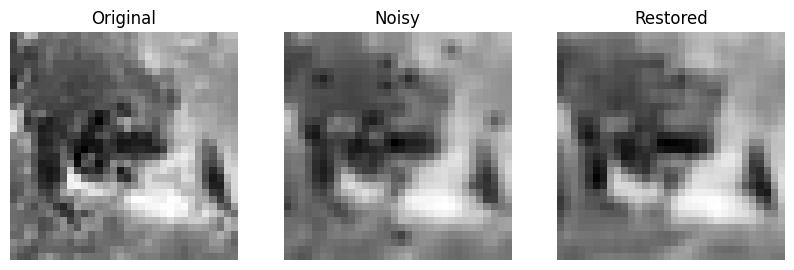

In [7]:
def show_images(original, noisy, restored, idx):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original[idx].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy[idx].reshape(32, 32), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(restored[idx].reshape(32, 32), cmap='gray')
    plt.title("Restored")
    plt.axis('off')

    plt.show()


show_images(x_test_gray, x_test_noisy, x_test_restored, sample_idx)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import time

In [9]:
def get_dataloaders(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader


In [10]:
def get_model(model_name, num_classes=100):
    if model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    else:
        raise ValueError("Model not supported")
    return model

In [11]:
def train_model(model, trainloader, criterion, optimizer, device, epochs=5):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
    return model

In [12]:
def evaluate_model(model, testloader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader, testloader = get_dataloaders()

    models_to_train = ['alexnet', 'vgg16']
    results = {}

    for model_name in models_to_train:
        print(f"Training {model_name}...")
        model = get_model(model_name)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        start_time = time.time()
        trained_model = train_model(model, trainloader, criterion, optimizer, device)
        inference_time = time.time() - start_time

        print(f"Evaluating {model_name}...")
        accuracy = evaluate_model(trained_model, testloader, device)

        results[model_name] = {'accuracy': accuracy, 'inference_time': inference_time}

    print("\nComparison Results:")
    for model, result in results.items():
        print(f"{model}: Accuracy={result['accuracy']:.2f}%, Inference Time={result['inference_time']:.2f}s")

100%|██████████| 169M/169M [00:18<00:00, 9.09MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training alexnet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 169MB/s]


Epoch 1, Loss: 4.26310812298904
Epoch 2, Loss: 3.719939999873071
Epoch 3, Loss: 3.351072284571655
Epoch 4, Loss: 3.114847659150048
Epoch 5, Loss: 2.9463502455245503
Evaluating alexnet...
Accuracy: 28.06%
Training vgg16...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.8MB/s]


Epoch 1, Loss: 4.611143572556088
Epoch 2, Loss: 4.608007640180076
Epoch 3, Loss: 4.6075922107452625
